# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-20 05:13:26--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  18.3MB/s    in 7.8s    

2022-09-20 05:13:34 (14.3 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [41]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
x = X.astype('float32')

y = y.astype('int32')
X = X.astype('float32') #/ 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

17165


Text(0.5, 1.0, 'C')

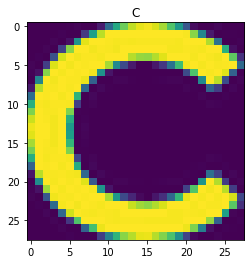

In [13]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18723)
print(i)
plt.imshow( X[i,:,:,0] )
plt.title( "ABCDEFGHIJ"[y[i]] )

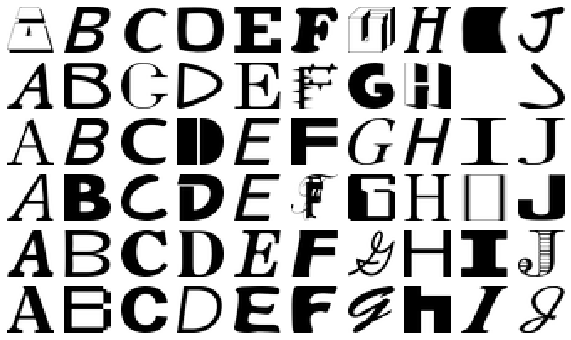

In [14]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [15]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [16]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

## X : Min-Max Scaling

In [17]:
max_x, min_x = x_train.max(), x_train.min()

max_x, min_x

(1.0, 0.0)

In [18]:
x_train = (x_train - max_x) / max_x
x_test = (x_test - max_x) / max_x

## Y : One-Hot Encoding

In [19]:
from tensorflow.keras.utils import to_categorical

class_n = len(np.unique(y_train))

y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

## Keras로 자유롭게 CNN 모델링

1. [이 구조를 미니 버전으로 활용해봐도 좋다](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
2. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.

In [21]:
from tensorflow import keras

# 1. 세션 클리어
keras.backend.clear_session()

# 2. 레이어 사슬 엮기
il = keras.layers.Input(shape=(28, 28, 1))
cl = keras.layers.Conv2D(filters=64,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(il)
cl = keras.layers.Conv2D(filters=64,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(cl)
bl = keras.layers.BatchNormalization()(cl)
ml = keras.layers.MaxPool2D(pool_size=(2,2),
                            strides=(2,2))(bl)
dl = keras.layers.Dropout(0.25)(ml)

cl = keras.layers.Conv2D(filters=128,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(dl)
cl = keras.layers.Conv2D(filters=128,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(cl)
bl = keras.layers.BatchNormalization()(cl)
ml = keras.layers.MaxPool2D(pool_size=(2,2),
                            strides=(2,2))(bl)
dl = keras.layers.Dropout(0.25)(ml)

cl = keras.layers.Conv2D(filters=256,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(dl)
cl = keras.layers.Conv2D(filters=256,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(cl)
cl = keras.layers.Conv2D(filters=256,
                         kernel_size=(3,3),
                         padding='same',
                         activation='relu')(cl)
bl = keras.layers.BatchNormalization()(cl)
ml = keras.layers.MaxPool2D(pool_size=(2,2),
                            strides=(2,2))(bl)
dl = keras.layers.Dropout(0.25)(ml)

fl = keras.layers.Flatten()(dl)
hl = keras.layers.Dense(1024, activation='relu')(fl)
bl = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.35)(bl)
ol = keras.layers.Dense(10, activation='softmax')(dl)

# 3. 모델 생성 시작과 끝 연결
model = keras.models.Model(il, ol)

# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 5. 모델 구조 확인
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0     

## Early Stopping을 이용한 학습

1. validation_split = 0.2
2. 1 epoch 돌려가며 빠르게 학습되는 batch_size를 찾을 것
3. 5 epoch 전보다 val_loss가 개선되지 않았으면 멈추는 얼리스토핑

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, batch_size = 128, callbacks=[es], verbose=1, validation_split=0.2)

Epoch 1/1000
94/94 [==============================] - 3s 32ms/step - loss: 0.1272 - accuracy: 0.9596 - val_loss: 0.2639 - val_accuracy: 0.9266
Epoch 2/1000
94/94 [==============================] - 3s 32ms/step - loss: 0.1085 - accuracy: 0.9646 - val_loss: 0.2207 - val_accuracy: 0.9379
Epoch 3/1000
94/94 [==============================] - 3s 32ms/step - loss: 0.0960 - accuracy: 0.9698 - val_loss: 0.2164 - val_accuracy: 0.9433
Epoch 4/1000
94/94 [==============================] - 3s 32ms/step - loss: 0.0852 - accuracy: 0.9732 - val_loss: 0.2213 - val_accuracy: 0.9449
Epoch 5/1000
94/94 [==============================] - 3s 31ms/step - loss: 0.0707 - accuracy: 0.9774 - val_loss: 0.2336 - val_accuracy: 0.9379
Epoch 6/1000
94/94 [==============================] - 3s 33ms/step - loss: 0.0614 - accuracy: 0.9806 - val_loss: 0.2360 - val_accuracy: 0.9426
Epoch 7/1000
94/94 [==============================] - 3s 35ms/step - loss: 0.0618 - accuracy: 0.9802 - val_loss: 0.2609 - val_accuracy: 0.9332

* 예측값 생성

In [30]:
y_pred = model.predict(x_test)

* 생성한 예측값을 y_test 구조와 같게 만든다

In [31]:
pred_array = np.zeros(shape=(y_pred.shape[0], y_pred.shape[1]))
idx = 0

for arr_val in y_pred :
    # print(arr_val)
    pred_array[idx][arr_val.argmax()] = 1
    idx += 1

In [32]:
pred_array.shape

(3745, 10)

* 성능 평가

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
print( f'{accuracy_score(y_test, pred_array):.4f}' )

0.9509


## 문자 이미지 시각화

In [35]:
import random as rd

In [36]:
character = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

* 실제 성능 확인을 위해 반복 실행!

id = 649
실제 문자 : J
모델의 문자 예측 : J
모델의 문자별 예측 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]
정답


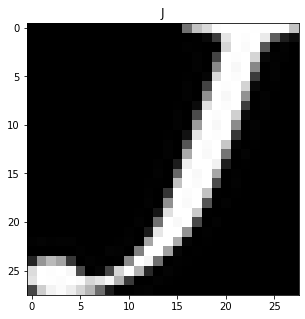

In [38]:
rand_n = rd.randrange(0, 3744)

print(f'id = {rand_n}')
print(f'실제 문자 : {character[y_test[rand_n].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[rand_n].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[rand_n]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[rand_n].argmax() == y_pred[rand_n].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[rand_n].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_test[rand_n].argmax()] )
plt.show()

* 틀린 문자만 확인해봅시다!

id = 1123
실제 문자 : I
모델의 문자 예측 : J
모델의 문자별 예측 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0. 12. 88.]
오답


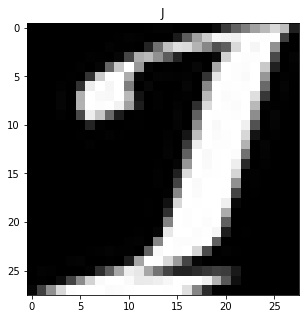

In [40]:
t_f = ( y_test.argmax(axis=1) == y_pred.argmax(axis=1) )
false_id = np.where(t_f==False)[0]
false_n = len(false_id)

id = false_id[rd.randrange(0, false_n)]

print(f'id = {id}')
print(f'실제 문자 : {character[y_test[id].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[id].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[id]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[id].argmax() == y_pred[id].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[id].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_pred[id].argmax()] )
plt.show()